In [29]:

# used libraries 
import json
import pandas as pd
import matplotlib.pyplot as plt

# Similar Player Component used libraries 
from sklearn.metrics.pairwise import cosine_similarity # Cosine Similarity
from sklearn.cluster import KMeans # Kmeans clustering

# evaluation
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr
from scipy.stats import kendalltau

# Scouter AI Component used libraries
import os 
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import AIMessage, HumanMessage, SystemMessage

# evaluation
from rouge_score import rouge_scorer
from bert_score import score

In [30]:
df = pd.read_csv("football-player-stats-2023.csv")

In [31]:
df.Rk.values[0]

0

In [32]:
df

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,Playing Time MP,Performance Gls,...,Total Cmp,Total Att,Total Cmp%,Total TotDist,Total PrgDist,KP,1/3,PPA,CrsPA,PrgP
0,0,Brenden Aaronson,USA,"MF,FW",Leeds United,Premier League,23,2000,36,1,...,592,797,74.3,7577,2182,46,47,16,4,86
1,1,Paxten Aaronson,USA,"MF,DF",Eint Frankfurt,Bundesliga,20,2003,7,0,...,51,71,71.8,659,109,1,3,0,0,6
2,2,James Abankwah,IRL,DF,Udinese,Serie A,19,2004,2,0,...,23,29,79.3,375,79,0,0,0,0,0
3,3,George Abbott,ENG,MF,Tottenham,Premier League,18,2005,1,0,...,1,1,100.0,8,0,0,0,0,0,0
4,4,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,36,1987,37,1,...,1679,2031,82.7,32967,13407,13,155,5,0,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,2717,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,24,1999,36,1,...,1545,1812,85.3,26783,8092,20,175,23,1,184
2718,2718,Szymon Żurkowski,POL,MF,"Fiorentina, Spezia",Serie A,26,1997,12,0,...,87,120,158.8,1282,294,1,10,2,0,11
2719,2719,Martin Ødegaard,NOR,MF,Arsenal,Premier League,25,1998,37,15,...,1449,1804,80.3,22540,6014,76,135,91,4,266
2720,2720,Milan Đurić,BIH,FW,Hellas Verona,Serie A,33,1990,28,1,...,268,523,51.2,3119,740,21,27,5,0,29


In [33]:
df_player_norm = df.copy()

In [34]:
custom_mapping = {
    'GK': 1,
    'DF,FW': 4,
    'MF,FW': 8,
    'DF': 2,
    'DF,MF': 3,
    'MF,DF': 5,
    'MF': 6,
    'FW,DF': 7,
    'FW,MF': 9,
    'FW': 10
}

# Apply custom mapping to the 'Pos' column
df_player_norm['Pos'] = df_player_norm['Pos'].map(custom_mapping)

In [35]:
df_player_norm

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,Playing Time MP,Performance Gls,...,Total Cmp,Total Att,Total Cmp%,Total TotDist,Total PrgDist,KP,1/3,PPA,CrsPA,PrgP
0,0,Brenden Aaronson,USA,8,Leeds United,Premier League,23,2000,36,1,...,592,797,74.3,7577,2182,46,47,16,4,86
1,1,Paxten Aaronson,USA,5,Eint Frankfurt,Bundesliga,20,2003,7,0,...,51,71,71.8,659,109,1,3,0,0,6
2,2,James Abankwah,IRL,2,Udinese,Serie A,19,2004,2,0,...,23,29,79.3,375,79,0,0,0,0,0
3,3,George Abbott,ENG,6,Tottenham,Premier League,18,2005,1,0,...,1,1,100.0,8,0,0,0,0,0,0
4,4,Yunis Abdelhamid,MAR,2,Reims,Ligue 1,36,1987,37,1,...,1679,2031,82.7,32967,13407,13,155,5,0,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,2717,Martín Zubimendi,ESP,6,Real Sociedad,La Liga,24,1999,36,1,...,1545,1812,85.3,26783,8092,20,175,23,1,184
2718,2718,Szymon Żurkowski,POL,6,"Fiorentina, Spezia",Serie A,26,1997,12,0,...,87,120,158.8,1282,294,1,10,2,0,11
2719,2719,Martin Ødegaard,NOR,6,Arsenal,Premier League,25,1998,37,15,...,1449,1804,80.3,22540,6014,76,135,91,4,266
2720,2720,Milan Đurić,BIH,10,Hellas Verona,Serie A,33,1990,28,1,...,268,523,51.2,3119,740,21,27,5,0,29


In [36]:
selected_features = ['Pos', 'Age','Playing Time MP', 'Performance Gls', 'Performance Ast',
       'Performance G+A', 'Performance G-PK', 'Performance Fls',
       'Performance Fld', 'Performance Crs', 'Performance Recov',
       'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
       'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
       'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
       'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
       'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
       'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
       'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
       'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
       'Performance Saves', 'Performance Save%', 'Performance CS',
       'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
       'SCA SCA', 'GCA GCA', 'Aerial Duels Won', 'Aerial Duels Lost',
       'Aerial Duels Won%', 'Total Cmp', 'Total Att', 'Total Cmp%',
       'Total TotDist', 'Total PrgDist', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']



In [37]:
df_player_norm.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born',
       'Playing Time MP', 'Performance Gls', 'Performance Ast',
       'Performance G+A', 'Performance G-PK', 'Performance Fls',
       'Performance Fld', 'Performance Crs', 'Performance Recov',
       'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
       'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
       'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
       'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
       'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
       'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
       'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
       'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
       'Performance Saves', 'Performance Save%', 'Performance CS',
       'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
       'SCA SCA', 'GC

In [38]:
# Apply MinMaxScaler normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_player_norm[selected_features] = scaler.fit_transform(df_player_norm[selected_features])

In [39]:
similarity = cosine_similarity(df_player_norm[selected_features])
similarity.shape

(2722, 2722)

In [40]:
similarity

array([[1.        , 0.60016401, 0.37790806, ..., 0.80921703, 0.65743717,
        0.908455  ],
       [0.60016401, 1.        , 0.77804174, ..., 0.52456207, 0.71103596,
        0.73739707],
       [0.37790806, 0.77804174, 1.        , ..., 0.39034622, 0.56162285,
        0.50332693],
       ...,
       [0.80921703, 0.52456207, 0.39034622, ..., 1.        , 0.56782906,
        0.81923528],
       [0.65743717, 0.71103596, 0.56162285, ..., 0.56782906, 1.        ,
        0.78521719],
       [0.908455  , 0.73739707, 0.50332693, ..., 0.81923528, 0.78521719,
        1.        ]])

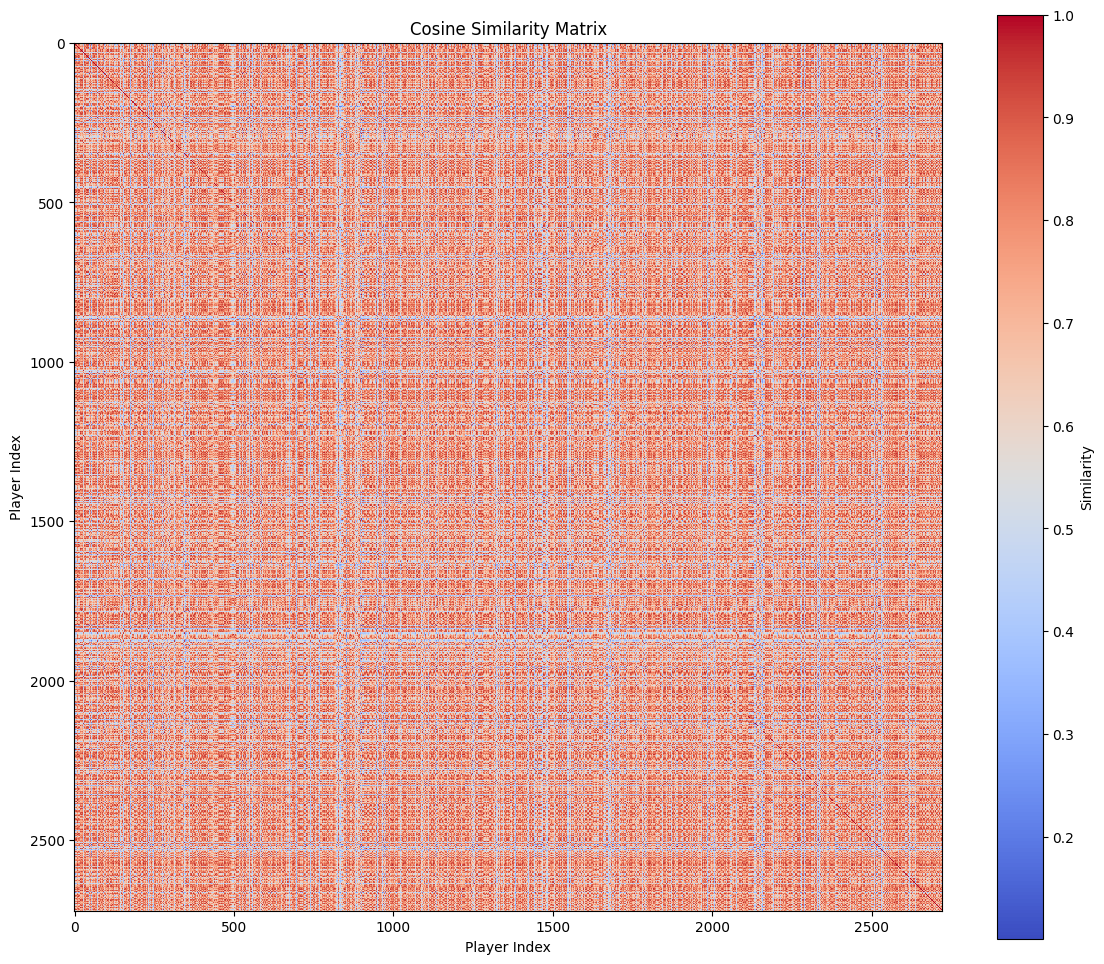

In [41]:
# Plot Cosine Similarity Matrix

plt.figure(figsize=(14, 12))
plt.imshow(similarity, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Player Index')
plt.ylabel('Player Index')
plt.show()

In [52]:

# The result is then converted into a list of tuples, where each tuple contains two elements: 
# the index of the element in the original list and the similarity score between the specific element and that element.
similarity_score = list(enumerate(similarity[30]))

In [53]:
# Sort in descending order
similar_players = sorted(similarity_score, key=lambda x:x[1], reverse=True)
print(similar_players)

[(30, 1.0000000000000004), (1000, 0.9654953157441784), (2329, 0.9607637831564234), (1695, 0.9553875082506249), (2166, 0.9553035032248165), (2527, 0.9545943633853861), (105, 0.9529520056257142), (1904, 0.9526451004006894), (2435, 0.9517813500229872), (429, 0.951684139840701), (1968, 0.9514351101507252), (1031, 0.9505770824184305), (572, 0.949973891234094), (276, 0.9499584282644505), (1583, 0.9497568346414367), (406, 0.9482712662763011), (1209, 0.9480740938409048), (1273, 0.9474308596493606), (350, 0.9469355073104891), (784, 0.9467690699524176), (343, 0.9464736074160306), (1485, 0.9461859660353609), (1648, 0.9461369431794663), (1654, 0.9460874646760181), (2369, 0.9459978019617602), (2242, 0.945431093730844), (2266, 0.9443431664115151), (1646, 0.9435409429723773), (1912, 0.9430240280537525), (2333, 0.9429080560279983), (524, 0.9427681915185402), (1047, 0.9424176826252757), (1829, 0.9405023501154275), (1432, 0.9404172635415472), (994, 0.9403046268571982), (1744, 0.9400892123854142), (2195,

In [54]:
# Creating a list to store the data of similar players
similar_players_data = []

# Cycle to extract information from similar players
for player in similar_players[1:11]:
    index = player[0]
    player_records = df[df['Rk'] == index]
    if not player_records.empty:
        player_data = player_records.iloc[0] 
        similar_players_data.append(player_data)

# Creating a DataFrame from the data of similar players
similar_players_df = pd.DataFrame(similar_players_data)

similar_players_df

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,Playing Time MP,Performance Gls,...,Total Cmp,Total Att,Total Cmp%,Total TotDist,Total PrgDist,KP,1/3,PPA,CrsPA,PrgP
1000,1000,Nicolás González,ESP,MF,Valencia,La Liga,21,2002,26,1,...,676,778,86.9,10855,3185,12,92,9,0,81
2329,2329,Ibrahima Sissoko,FRA,MF,Strasbourg,Ligue 1,26,1997,26,0,...,489,636,76.9,8178,2320,11,50,15,3,67
1695,1695,Luis Milla,ESP,MF,Getafe,La Liga,29,1994,27,0,...,756,974,77.6,13767,4551,29,99,6,3,104
2166,2166,Pablo Rosario,NED,"MF,DF",Nice,Ligue 1,26,1997,31,0,...,930,1049,88.7,16595,5260,19,84,15,3,112
2527,2527,Lesley Ugochukwu,FRA,MF,Rennes,Ligue 1,19,2004,26,0,...,566,648,87.3,10531,2415,3,43,3,0,50
105,105,Robert Andrich,GER,MF,Leverkusen,Bundesliga,29,1994,29,2,...,1218,1455,83.7,19896,5759,18,77,11,2,99
1904,1904,Salih Özcan,TUR,MF,Dortmund,Bundesliga,25,1998,26,0,...,882,999,88.3,13911,3887,9,75,7,1,81
2435,2435,Renato Tapia,PER,"MF,DF",Celta Vigo,La Liga,28,1995,28,0,...,687,811,84.7,13506,3634,9,63,7,1,68
429,429,Emre Can,GER,MF,Dortmund,Bundesliga,29,1994,27,2,...,1153,1288,89.5,20793,5986,20,111,7,1,99
1968,1968,Pepín,EQG,MF,Monza,Serie A,27,1996,25,0,...,554,666,83.2,9428,2784,9,67,18,2,74


/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

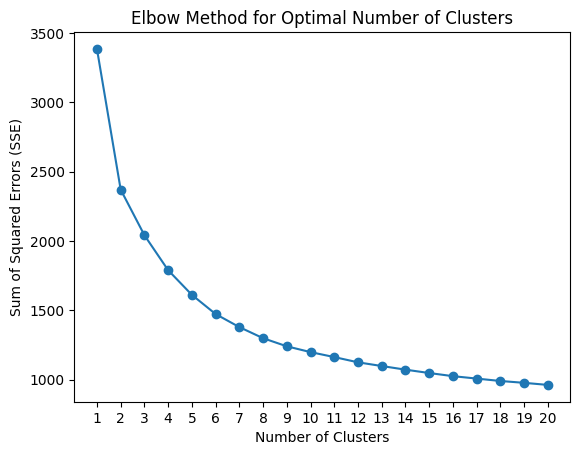

In [55]:
# Calculation of SSE (inertia) for different cluster values
sse_values = []
possible_clusters = range(1, 21)  # test with range of 20 clusters

for num_clusters in possible_clusters:
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_player_norm[selected_features])
    sse_values.append(kmeans_model.inertia_)

# Visualisation of SSE trend
plt.plot(possible_clusters, sse_values, marker='o')
plt.xticks(possible_clusters, possible_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [56]:
# Specifies the desired number of clusters
num_clusters = 4

# Create an instance of the K-Means model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)

# Train the model on player features
kmeans_model.fit(df_player_norm[selected_features])

# Get the cluster labels assigned to players
cluster_labels = kmeans_model.labels_

# Add cluster labels to the player dataframe
df_player_norm['Cluster'] = cluster_labels

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [74]:
df_player_norm[df_player_norm['Cluster']==2]

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,Playing Time MP,Performance Gls,...,Total Att,Total Cmp%,Total TotDist,Total PrgDist,KP,1/3,PPA,CrsPA,PrgP,Cluster
1,1,Paxten Aaronson,USA,0.444444,Eint Frankfurt,Bundesliga,0.153846,2003,0.103448,0.000000,...,0.022029,0.373764,0.012017,0.003000,0.008403,0.008065,0.000000,0.000000,0.018692,2
2,2,James Abankwah,IRL,0.111111,Udinese,Serie A,0.115385,2004,0.017241,0.000000,...,0.008998,0.412806,0.006838,0.002174,0.000000,0.000000,0.000000,0.000000,0.000000,2
3,3,George Abbott,ENG,0.555556,Tottenham,Premier League,0.076923,2005,0.000000,0.000000,...,0.000310,0.520562,0.000146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
8,8,Oliver Abildgaard,DEN,0.555556,Hellas Verona,Serie A,0.423077,1996,0.206897,0.000000,...,0.060503,0.307132,0.035431,0.025596,0.050420,0.045699,0.025000,0.054054,0.046729,2
9,9,Matthis Abline,FRA,0.888889,"Auxerre, Rennes",Ligue 1,0.153846,2003,0.500000,0.083333,...,0.037232,0.585112,0.023998,0.007293,0.058824,0.021505,0.033333,0.027027,0.031153,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,2713,Tanguy Zoukrou,FRA,0.111111,Troyes,Ligue 1,0.153846,2003,0.120690,0.000000,...,0.068570,0.449766,0.058207,0.032256,0.008403,0.018817,0.000000,0.000000,0.034268,2
2714,2714,Kurt Zouma,FRA,0.111111,West Ham,Premier League,0.500000,1994,0.413793,0.055556,...,0.257834,0.439355,0.245810,0.122117,0.008403,0.051075,0.016667,0.000000,0.096573,2
2715,2715,Petar Zovko,BIH,0.000000,Spezia,Serie A,0.192308,2002,0.000000,0.000000,...,0.011170,0.318064,0.012455,0.012605,0.000000,0.002688,0.000000,0.000000,0.000000,2
2718,2718,Szymon Żurkowski,POL,0.555556,"Fiorentina, Spezia",Serie A,0.384615,1997,0.189655,0.000000,...,0.037232,0.826653,0.023378,0.008092,0.008403,0.026882,0.016667,0.000000,0.034268,2


In [57]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=4): {silhouette_score(df_player_norm[selected_features], cluster_labels)}')

Silhouette Score(n=4): 0.274574188555236


In [60]:
# Select the player of interest (target)
target_player = df_player_norm[df_player_norm['Rk'] == 0]
target_features = target_player[selected_features]
target_cluster = target_player['Cluster'].iloc[0]  # Get the cluster label of the target player

# Filter the dataframe for players in the same cluster as the target player
similar_players_cluster_df = df_player_norm[df_player_norm['Cluster'] == target_cluster].copy()

# Calculate cosine similarity between the target player and other players in the same cluster
similarities = cosine_similarity(target_features, similar_players_cluster_df[selected_features])
similarities = similarities[0] * 100

# Add the 'Similarity' column to the dataframe using .loc
similar_players_cluster_df.loc[:, 'Similarity'] = similarities

# Sort the DataFrame based on the 'Similarity' column in descending order
similar_players_cluster_df = similar_players_cluster_df.sort_values(by='Similarity', ascending=False)

# Select from the second to the 11th element (remembering that indexing starts from 0)
similar_players_cluster_df = similar_players_cluster_df.iloc[1:11]

# Retrieve the non-normalized data from the original dataframe
similar_players_cluster_df = df[df['Rk'].isin(similar_players_cluster_df['Rk'])]

similar_players_cluster_df

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,Playing Time MP,Performance Gls,...,Total Cmp,Total Att,Total Cmp%,Total TotDist,Total PrgDist,KP,1/3,PPA,CrsPA,PrgP
351,351,Jarrod Bowen,ENG,"FW,MF",West Ham,Premier League,27,1996,38,6,...,552,881,62.7,8725,2552,48,39,24,9,72
492,492,Fares Chaïbi,ALG,"FW,MF",Toulouse,Ligue 1,21,2002,36,5,...,742,1018,72.9,11489,3144,30,68,27,5,101
727,727,Ritsu Doan,JPN,"MF,FW",Freiburg,Bundesliga,25,1998,33,5,...,437,625,69.9,6572,1840,27,44,28,5,69
1160,1160,Adrien Hunou,FRA,"MF,FW",Angers,Ligue 1,29,1994,34,4,...,572,753,76.0,8441,2005,18,38,12,1,62
1274,1274,Jakub Kamiński,POL,"FW,DF",Wolfsburg,Bundesliga,21,2002,31,4,...,495,667,74.2,7398,2278,28,30,39,5,78
1865,1865,Michael Olise,FRA,"FW,MF",Crystal Palace,Premier League,22,2001,37,2,...,985,1420,69.4,16792,5022,72,72,53,16,133
1915,1915,Isaac Palazón Camacho,ESP,"FW,MF",Rayo Vallecano,La Liga,29,1994,37,9,...,979,1376,71.1,16672,4781,66,84,47,11,127
2017,2017,Gonzalo Plata,ECU,FW,Valladolid,La Liga,23,2000,34,1,...,582,782,74.4,7367,1681,37,28,19,3,54
2077,2077,Jacob Ramsey,ENG,"MF,FW",Aston Villa,Premier League,22,2001,35,6,...,728,889,81.9,10240,2665,42,67,28,4,98
2643,2643,Joe Willock,ENG,MF,Newcastle Utd,Premier League,24,1999,35,3,...,777,951,81.7,12123,3082,39,91,34,8,121


In [62]:
os.environ['OPENAI_API_KEY'] = "sk-proj-nJLtRagMm9Q7Xu5fshELT3BlbkFJeK1vECmrZQw2NGoDJbNK"

In [63]:
# Feature for prompt
style_t = 'In this style, a team adapts to the ongoing game situations, changing their tactics based on what is happening on the field. It can be used to exploit opponent weaknesses or respond to unexpected situations.'
type_player = 'A player with experience, but not necessarily in the late stages of their career. They have solid skills and tactical knowledge acquired over time.'
league = 'Tactical and defensive football with an emphasis on defensive solidity and tactical play.'
ability = ['Aerial Ability', 'Speed', 'Vision', 'Agility', 'Finishing', 'Leadership', 'Game Intelligence']
formation = '4-3-3'

In [64]:
# Prompt Template without Role
prompt_ZS = PromptTemplate.from_template(
    """
    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the PLAYERS PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).
    THE PLAYERS ARE: {content}
    
    TEAM REQUIREMENTS:
    Style of play: {style_t}
    Player type required: {type_player}
    Preferred league: {league}
    Key ability: {ability}
    Ideal formation: {formation}
    """
)

In [65]:
# configuration LLM and Langchain
llm = ChatOpenAI(temperature=0.3, model="gpt-3.5-turbo") 
players_chain = LLMChain(llm=llm, prompt=prompt_ZS, verbose=True)

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [67]:
result_GPT_ZS = players_chain.run(player='Jarrod Bowen', content=similar_players_df['Player'], style_t=style_t, type_player=type_player, league=league, ability=ability, formation=formation)


/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new LLMChain chain...
Prompt after formatting:

    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the PLAYERS PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).
    THE PLAYERS ARE: 1000    Nicolás González
2329    Ibrahima Sissoko
1695          Luis Milla
2166       Pablo Rosario
2527    Lesley Ugochukwu
105       Robert Andrich
1904         Salih Özcan
2435        Renato Tapia
429             Emre Can
1968

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [68]:
prompt_AGOS = PromptTemplate.from_template(
    """
    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the DATA PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).

    DATA:
    ------------------------------------
    {content}
    ------------------------------------ 

    TEAM REQUIREMENTS:
    Style of play: {style_t}
    Player type required: {type_player}
    Preferred league: {league}
    Key ability: {ability}
    Ideal formation: {formation}

    EXAMPLE TO FOLLOW:
    ### Report
    After a detailed analysis of the data, we have identified candidates who best meet the requirements of your team. Below, we present three potential candidates:

    ##### Three potential candidates:

    **[Player X]**: Highlights strengths and addresses weaknesses based on data on the essential attributes for a player in his specific age group.
    **[Player Y]**: Highlights strengths and addresses weaknesses based on data regarding the attributes a player must necessarily possess in his specific age group.
    **[Player Z*]**: Highlighting strengths and addressing weaknesses based on attribute data that a player must necessarily possess in his specific age group.
    
    [Give reasons for choosing the chosen player over the others].

    The chosen player:
    [Name of player chosen].
    """
)

In [69]:
# configuration LLM and Langchain
llm = ChatOpenAI(temperature=0.3, model="gpt-3.5-turbo") 
players_chain = LLMChain(llm=llm, prompt=prompt_AGOS, verbose=True)

In [71]:
result_GPT_AGOS = players_chain.run(player="Joe Willock", content=similar_players_df, style_t=style_t, type_player=type_player, league=league, ability=ability, formation=formation)




> Entering new LLMChain chain...
Prompt after formatting:

    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the DATA PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).

    DATA:
    ------------------------------------
            Rk            Player Nation    Pos       Squad        Comp  Age  Born  \
1000  1000  Nicolás González    ESP     MF    Valencia     La Liga   21  2002   
2329  2329  Ibrahima Sissoko    FRA

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [72]:
print(result_GPT_AGOS)

NameError: name 'result_GPT_AGOS' is not defined